# Preamble

In [1]:
%load_ext lab_black

In [2]:
# Google Colab
#!git clone https://github.com/Jez-Carter/Bias_Correction
# !pip install numpyro

In [3]:
# Importing Packages

import os

import timeit

import iris
import iris.quickplot as qplt
from iris.analysis.cartography import unrotate_pole
from iris.coords import AuxCoord
import iris.coord_categorisation
from iris.util import equalise_attributes
from iris.util import unify_time_units

import numpy as np
from numpy import meshgrid

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc("figure", figsize=(10, 10))

os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
# fixr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import AxesGrid

from scipy import stats
from scipy.optimize import minimize

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH
from numpyro.distributions import constraints

import jax.numpy as jnp
from jax import random, vmap, jit
import jax.scipy.stats.gamma as jgamma

# Importing Project Modules:

from src.netcdf_functions import pcolormesh_basemapplot


# from statsmodels.tsa.seasonal import STL

/data/conda/bc/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/data/conda/bc/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


# Estimating PDF parameter values

From previous literature (Lima, 2021, https://doi.org/10.1016/j.jhydrol.2021.126095) it seems reasonable to assume a Bernoulli-Gamma distribution for daily snowfall. This has the form:

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

The Bernoulli part gives the probability of rainfall (p) or no rainfall (1-p) on a given day at the site \(j\) for month \(k\) and the Gamma part gives the probability of an intensity of rainfall ($y_{jk}$) on that day given rainfall occurs. The gamma distribution has shape parameter $\alpha$ and scale parameter $\beta$. Note: it makes sense to include a Bernoulli term because of the discontinuity expected for the probability of no rainfall. The shape/scale parameters $\alpha$ and $\beta$ are estimated at every rainfall gauge and for each month of the year. 

Bayesian inference is used to estimate the parameters $p,\alpha,\beta$ for every rainfall gauge and month. 

\begin{equation}
    P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot \dfrac{P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} \propto P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

\begin{equation}
    P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}}) =
    (\prod_{jk} B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})) \cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

## Single Site, Single Month Example

For a single site and single month we have:

$P(Y=y) = B(1,p)\cdot G(y|\alpha,\beta)$

$B(1,p)\cdot G(y|\alpha,\beta) = \ p \cdot \dfrac{\beta^\alpha y^{\alpha-1}e^{-\beta y}}{\Gamma(\alpha)} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

$Likelihood = P(\boldsymbol{Y}|p,\alpha,\beta)=L(\boldsymbol{Y}|p,\alpha,\beta)=\prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)$

$Log Likehood = Log(L(\boldsymbol{Y}|p,\alpha,\beta))= LL(\boldsymbol{Y}|p,\alpha,\beta) =Log(\prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta))=\sum_{i} Log(B(1,p)\cdot G(y_{i}|\alpha,\beta))$

In [4]:
data = np.load(
    "data/single_site_jan_precip.npy"
)  # This is 38 years of daily data for January

In [5]:
data.shape

(1147,)

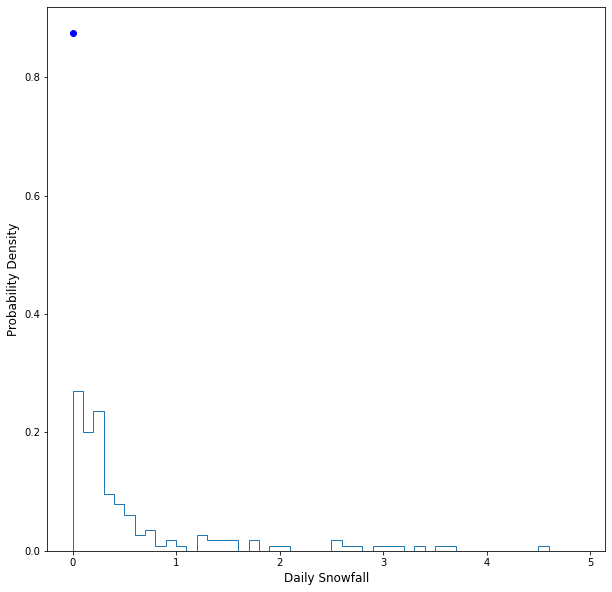

In [6]:
# Plotting the Probability Distribution as a Histogram

bins = np.arange(0, 5, 0.1)
bin_width = bins[1] - bins[0]
p = len(data[data != 0]) / len(data)
weight_value = p / bin_width / len(data[data != 0])
weights = np.full(len(data[data != 0]), weight_value)

plt.hist(
    data[data != 0],
    bins=bins,
    histtype="step",
    stacked=True,
    fill=False,
    weights=weights,
)
plt.plot(0, 1 - len(data[data != 0]) / len(data), "bo")
plt.xlabel("Daily Snowfall", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.show()

### Maximum Likelihood Estimation (MLE)

MLE assumes no correlation between parameters - e.g. $P(\alpha,\beta)=P(\alpha)\cdot P(\beta)$

MLE involves minimising the negative log likelihood (Note minimising and taking the log are done for compuational reasons): $-\sum_{i} Log(B(1,p)\cdot G(y_{i}|\alpha,\beta))$ where $y_i$ are our daily snowfall values.

In [7]:
# Defining the function to minimise:


def negloglikelihoodsum(params):
    p, alpha, scale = (
        params[0],
        params[1],
        params[2],
    )  # Note scale is 1/Beta and is the parameter used in the scipy.stats.gamma function instead of beta

    BGs = []  # Array to fill with Bernoulli-Gamma values for each y_i in the data

    for yi in data:
        if yi == 0:
            BG = 1 - p
        else:
            BG = p * stats.gamma.pdf(yi, a=alpha, loc=0, scale=scale)
        BGs.append(BG)

    return -np.sum(np.log(BGs))

In [8]:
# Applying Nelder-Mead Minimiser

# Parameter Guesses [p,alpha,scale]
guess = [0.5, 0.1, 1.0]

# Parameter Bounds (I've found this is needed to improve stability of the minimiser)
bounds = [
    (0.001, 1),
    (0.00001, 10),
    (0.00001, 10),
]

# Minimising Function
results = minimize(
    negloglikelihoodsum,
    guess,
    method="Nelder-Mead",
    options={"disp": True},
    bounds=bounds,
)
print(results["x"])

Optimization terminated successfully.
         Current function value: 528.789202
         Iterations: 105
         Function evaluations: 184
[0.12554491 0.84049561 0.85811062]


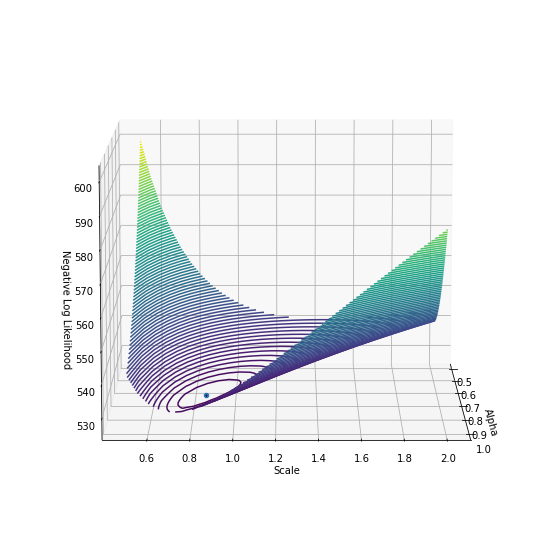

In [9]:
# Plotting the Negative LogLikelihood Space for Parameters Alpha and Beta with fixed P

n = 30
p = results["x"][0]
alphas = np.linspace(0.5, 1, n)
scales = np.linspace(0.5, 2, n)

alphas, scales = np.meshgrid(alphas, scales)
values = np.zeros((n, n))

for i in np.arange(0, n, 1):
    for j in np.arange(0, n, 1):
        values[i, j] = negloglikelihoodsum([p, alphas[i, j], scales[i, j]])

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.contour3D(alphas, scales, values, 100)  # , cmap='binary')

ax.set_xlabel("Alpha")
ax.set_ylabel("Scale")
ax.set_zlabel("Negative Log Likelihood")

ax.scatter(results["x"][1], results["x"][2], negloglikelihoodsum(results["x"]))

ax.view_init(10, 0)

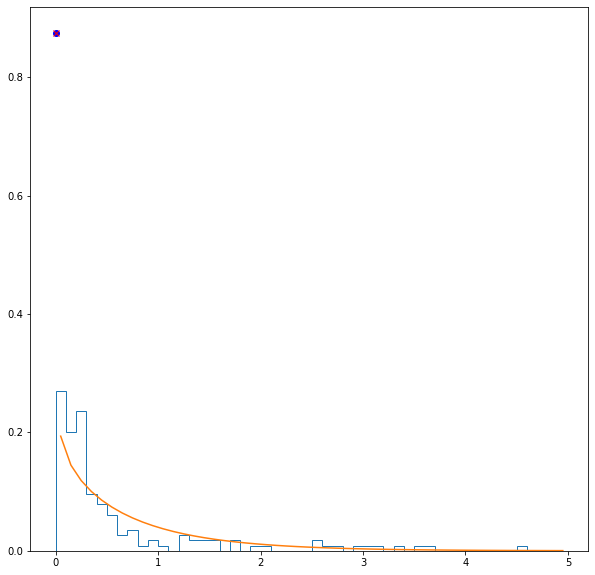

In [10]:
# Plotting the Probability Density Function that Maximises the Likelihood

bins = np.arange(0, 5, 0.1)
bin_centers = bins + bins[1] / 2

p, alpha, scale = results["x"]

estimates = []

for bin_center in bin_centers:
    result = p * stats.gamma.pdf(bin_center, a=alpha, loc=0, scale=scale)
    estimates.append(result)

bin_width = bins[1] - bins[0]
weight_value = p / bin_width / len(data[data != 0])
weights = np.full(len(data[data != 0]), weight_value)

plt.hist(
    data[data != 0],
    bins=bins,
    histtype="step",
    stacked=True,
    fill=False,
    weights=weights,
)
plt.plot(bin_centers, np.array(estimates))

plt.plot(0, 1 - p, "bo")
plt.plot(0, 1 - len(data[data != 0]) / len(data), "rx")

plt.show()

### Bayesian Inference

We are treating the parameters $[p,\alpha,\beta]$ as stochastic variables here with probability distributions to estimate (the posterior distribution). In addition to simply estimating the parameters that maximise our likelihood, this also allows us to estimate a credible interval and plot the uncertainty on our modelled PDF of snowfall.

$Posterior = \dfrac{Likelihood \cdot Prior}{Normalising Constant} $

$P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = \dfrac{P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} $

$P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) = \prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)\cdot P(p,\alpha,\beta)$

$P(\boldsymbol{y}) = \iiint\limits_{\theta} P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) \,dp\,d\alpha\,d\beta$

Note we don't need the normalising constant to estimate the most likely values of the parameters $\theta=[p,\alpha,\beta]$ (where we could do MLE but with priors included, which is MAP?), but we do need it for normalising the distributions of the parameters and so for uncertainty estimates. 


#### Example of Doing MCMC with Numpyro

"NumPyro is a small probabilistic programming library that provides a NumPy backend for Pyro. We rely on JAX for automatic differentiation and JIT compilation to GPU / CPU. This is an alpha release under active development, so beware of brittleness, bugs, and changes to the API as the design evolves."

Note Numpyro code can be constructed using similar syntax to numpy but using jax.numpy (jnp) instead of numpy (np).

In [11]:
data = np.load(
    "data/single_site_jan_precip.npy"
)  # This is 38 years of daily data for January

In [12]:
# Converting dataset to jax dataset
jdata = jnp.array(data)

In [13]:
class BernoulliGamma(numpyro.distributions.Distribution):
    support = constraints.positive

    def __init__(self, params):
        self.p = params[0]
        self.alpha = params[1]
        self.scale = params[2]
        super().__init__(batch_shape=jnp.shape(params[0]), event_shape=())

    def sample(self, key, sample_shape=()):
        raise NotImplementedError

    def log_prob(self, value):

        return jnp.log(1 - self.p) * jnp.sum(jnp.where(value == 0, 1, 0)) + jnp.sum(
            jnp.where(
                value != 0,
                jnp.log(
                    self.p
                    * jgamma.pdf(
                        jnp.where(value == 0, 1, value),
                        a=self.alpha,
                        loc=0,
                        scale=self.scale,
                    )  # Note I use np.where because jax and jit compiling doesn't work with list comprehension (e.g. [value[value!=0]]) (In addition I use it to avoid computing gamma for values of 0.
                ),
                0,
            )
        )

In [14]:
def single_site_model(dataset):

    # Define Priors (All Non-Informative)
    p = numpyro.sample("p", dist.Uniform(0, 1.0))
    alpha = numpyro.sample("alpha", dist.Gamma(0.001, 0.001))
    scale = numpyro.sample("scale", dist.Gamma(0.001, 0.001))

    # Include Likelihood
    numpyro.sample("obs", BernoulliGamma([p, alpha, scale]), obs=dataset)

In [15]:
# Numpyro syntax for running MCMC
starttime = timeit.default_timer()

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(single_site_model)
# kernel = HMC(model)
# kernel = BarkerMH(model)
num_samples = 1000
num_warmup = 500
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)  # ,num_chains=2)
mcmc.run(rng_key_, jdata)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

print("Time Taken:", timeit.default_timer() - starttime)

sample: 100%|██████████| 1500/1500 [00:04<00:00, 337.00it/s, 7 steps of size 6.44e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.84      0.08      0.84      0.72      0.97    605.46      1.00
         p      0.13      0.01      0.13      0.11      0.14    634.81      1.01
     scale      0.87      0.11      0.86      0.70      1.06    578.76      1.00

Number of divergences: 0
Time Taken: 7.264142692089081


In [16]:
# Plotting Likelihood against PDF of Data
ps = jnp.expand_dims(samples_1["p"], -1)
alphas = jnp.expand_dims(samples_1["alpha"], -1)
scales = jnp.expand_dims(samples_1["scale"], -1)

bins = np.arange(0, 5, 0.1)
bin_centers = bins + bins[1] / 2

likelihood_values = ps * jgamma.pdf(bin_centers, a=alphas, loc=0, scale=scales)

zero_likelihood_values = 1 - ps

In [17]:
# Finding mean values of the likelihood and 10th percentiles.
mean_l = jnp.mean(jnp.array(likelihood_values), axis=0)
hpdi_l = hpdi(jnp.array(likelihood_values), 0.95)
lower_l = hpdi_l[0]
upper_l = hpdi_l[1]

zero_mean_l = jnp.mean(jnp.array(zero_likelihood_values), axis=0)
zero_hpdi_l = hpdi(jnp.array(zero_likelihood_values), 0.95)
zero_lower_l = zero_hpdi_l[0]
zero_upper_l = zero_hpdi_l[1]
zero_lower_error = zero_mean_l - zero_lower_l
zero_upper_error = zero_upper_l - zero_mean_l
error = np.array([zero_lower_error[0], zero_upper_error[0]]).reshape(2, 1)

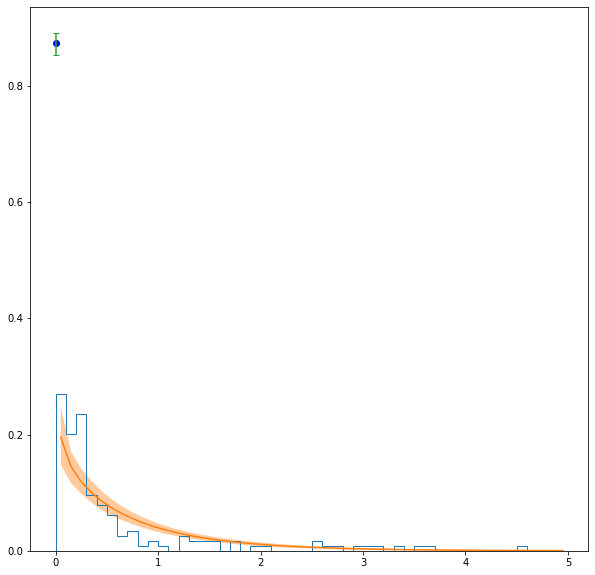

In [18]:
bin_width = bins[1] - bins[0]
p_data = len(data[data != 0]) / len(data)
weight_value = p_data / bin_width / len(data[data != 0])
weights = np.full(len(data[data != 0]), weight_value)

plt.hist(
    data[data != 0],
    bins=bins,
    histtype="step",
    stacked=True,
    fill=False,
    weights=weights,
)

plt.plot(bin_centers, mean_l)
plt.fill_between(bin_centers, y1=lower_l, y2=upper_l, alpha=0.4)

plt.plot(0, 1 - ps.mean(), "bo")
# plt.plot(0,1-p_data,'rx')
plt.errorbar(0, zero_mean_l, yerr=error, capsize=3)

plt.show()

In [19]:
numpyro.sample("a", dist.Gamma(0.001, 0.001), rng_key=rng_key)

DeviceArray(1.1754943e-35, dtype=float32)

## Multiple Sites, Multiple Months Example

For multiple sites (j) and multiple months (k) we have:

$P(\boldsymbol{Y}=\boldsymbol{y_i}) = B(1,\boldsymbol{p})\cdot G(\boldsymbol{y_i}|\boldsymbol{\alpha},\boldsymbol{\beta})$

Where:

$\boldsymbol{Y}=[Y_{00},Y_{01},Y_{1,0},...,Y_{jk}]$

$\boldsymbol{y}=[y_{00},y_{01},y_{1,0},...,y_{jk}]$

$\boldsymbol{p}=[p_{00},p_{01},p_{1,0},...,p_{jk}]$

$\boldsymbol{\alpha}=[\alpha_{00},\alpha_{01},\alpha_{1,0},...,\alpha_{jk}]$

$\boldsymbol{\beta}=[\beta_{00},\beta_{01},\beta_{1,0},...,\beta_{jk}]$

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

Now in Lima, 2021 to deal with the impact of seasonality the model is run for individual months (k) at a time. It is also noted that there exists a spatial correlation between $\alpha_{jk}$ and $\beta_{jk}$, which we want to preserve in the model and so we specify $\beta_{jk}$ as a log normally distributed linear function of $\alpha_{jk}$:

$\beta_{jk} \sim  LN(a_0+a_1 \cdot \alpha_{jk},\sigma^{2})$

The set of parameters $[a_0,a_1,\sigma]$ are hyper-parameters, in that they are not dependent on j (Note they are allowed to be dependent on k).


$Likelihood = P(\boldsymbol{Y}|\boldsymbol{p},\boldsymbol{\alpha},\beta) = \prod_\limits{jk}P(Y_{jk}|p_{jk},\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2) = \prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2)$

$Log Likehood = Log(\prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2)) = \sum_\limits{ijk} Log(B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0k},a_{1k},{\sigma_k}^2))$

### Bayesian Inference

In [20]:
jan_data = np.load(
    "data/multi_site_jan_precip.npy"
)  # This is 38 years of daily data for January

feb_data = np.load(
    "data/multi_site_feb_precip.npy"
)  # This is 38 years of daily data for February

In [21]:
data_list = [jan_data, feb_data]

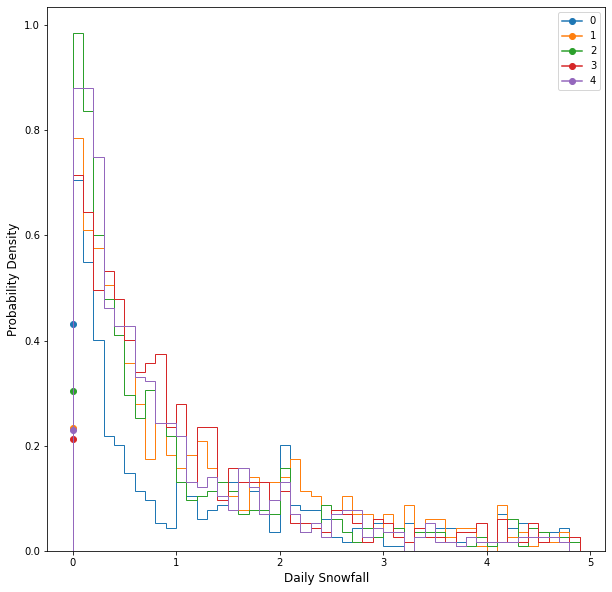

In [22]:
# Plotting the Probability Distributions for each Site for January as a Histogram

for i in np.arange(0, 5, 1):
    data = data_list[0][:, i]
    bins = np.arange(0, 5, 0.1)
    bin_width = bins[1] - bins[0]
    p = len(data[data != 0]) / len(data)
    weight_value = p / bin_width / len(data[data != 0])
    weights = np.full(len(data[data != 0]), weight_value)

    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    plt.hist(
        data[data != 0],
        bins=bins,
        histtype="step",
        stacked=True,
        fill=False,
        weights=weights,
        color=color,
    )
    plt.plot(0, 1 - len(data[data != 0]) / len(data), marker="o", color=color, label=i)
    plt.xlabel("Daily Snowfall", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.legend()
    # plt.show()

In [23]:
# Converting dataset to jax dataset
jdata_list = [jnp.array(jan_data), jnp.array(feb_data)]

In [24]:
class BernoulliGamma(numpyro.distributions.Distribution):
    support = constraints.positive

    def __init__(self, params):
        self.p = params[0]
        self.alpha = params[1]
        self.scale = params[2]
        super().__init__(batch_shape=jnp.shape(params[0]), event_shape=())

    def sample(self, key, sample_shape=()):
        raise NotImplementedError

    def log_prob(self, value):

        return jnp.log(1 - self.p) * jnp.sum(
            jnp.where(value == 0, 1, 0), axis=0
        ) + jnp.sum(
            jnp.where(
                value != 0,
                jnp.log(
                    self.p
                    * jgamma.pdf(
                        jnp.where(value == 0, 1, value),
                        a=self.alpha,
                        loc=0,
                        scale=self.scale,
                    )  # Note I use np.where because jax and jit compiling doesn't work with list comprehension (e.g. [value[value!=0]]) (In addition I use it to avoid computing gamma for values of 0).
                ),
                0,
            ),
            axis=0,
        )

In [25]:
def parametric_dependency_model(data_seperate_month_list):

    # Hyper-Params: (These the parameters used to parameterise beta as a function of alpha
    a0 = numpyro.sample(f"a0", dist.Uniform(-10, 10.0))
    a1 = numpyro.sample(f"a1", dist.Uniform(-10, 10.0))
    betavar = numpyro.sample(f"betavar", dist.InverseGamma(0.001, 0.001))

    months = len(data_seperate_month_list)
    sites = data_seperate_month_list[0].shape[1]

    for k in np.arange(0, months, 1):
        with numpyro.plate("Sites", sites) as j:
            # Plate essentially vectorises all the below, so for example where sites = 5, the shape of p,alpha and scale defined below will be vectors of length 5
            data = data_seperate_month_list[k][:, j]

            p = numpyro.sample(f"p{k}", dist.Uniform(0, 1.0))
            alpha = numpyro.sample(f"alpha{k}", dist.Gamma(0.001, 0.001))
            scale = jnp.reciprocal(
                numpyro.sample(
                    f"beta{k}",
                    dist.LogNormal(
                        a0 + a1 * alpha,
                        betavar,
                    ),
                )
            )

            numpyro.sample(
                f"obs{k}",
                BernoulliGamma([p, alpha, scale]),
                obs=data,
            )

In [26]:
# Numpyro syntax for running MCMC
starttime = timeit.default_timer()

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(parametric_dependency_model)
# kernel = HMC(model)
# kernel = BarkerMH(model)
num_samples = 2000
num_warmup = 1000
mcmc = MCMC(
    kernel, num_warmup=num_warmup, num_samples=num_samples
)  # ,chain_method='vectorized',num_chains=2)
mcmc.run(rng_key_, jdata_list)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

print("Time Taken:", timeit.default_timer() - starttime)

sample: 100%|██████████| 3000/3000 [01:06<00:00, 45.05it/s, 127 steps of size 4.26e-02. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     -3.58      0.78     -3.61     -4.77     -2.21   1501.53      1.00
        a1      3.51      0.95      3.56      1.86      4.94   1484.26      1.00
 alpha0[0]      0.66      0.03      0.66      0.61      0.70   1552.41      1.00
 alpha0[1]      0.85      0.03      0.84      0.79      0.90   2490.54      1.00
 alpha0[2]      0.87      0.04      0.87      0.81      0.92   1753.05      1.00
 alpha0[3]      0.89      0.03      0.88      0.83      0.94   2033.56      1.00
 alpha0[4]      0.83      0.03      0.83      0.77      0.89   1482.80      1.00
 alpha1[0]      0.70      0.04      0.70      0.65      0.76   2035.78      1.00
 alpha1[1]      0.80      0.03      0.80      0.74      0.85   2109.34      1.00
 alpha1[2]      0.83      0.03      0.83      0.77      0.88   2198.22      1.00
 alpha1[3]      0.93      0.04      0.93      0.87      1.00   1448.80      1.00
 alpha1[4]      0.83      0

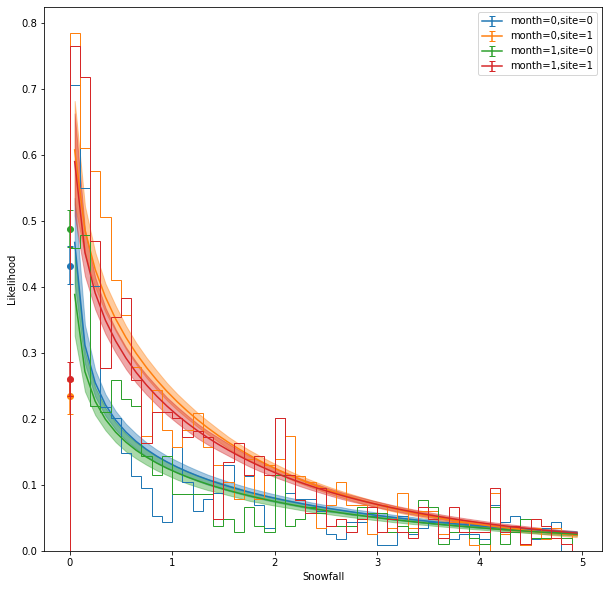

In [27]:
# Plotting the PDFs estimated for 2 different sites for January and February (The credible interval containing 95% of expected variation is also plotted)

for k in np.arange(0, 2, 1):
    for j in np.arange(0, 2, 1):

        ps = jnp.expand_dims(samples_1[f"p{k}"], -1)[:, j]
        alphas = jnp.expand_dims(samples_1[f"alpha{k}"], -1)[:, j]
        scales = jnp.reciprocal(jnp.expand_dims(samples_1[f"beta{k}"], -1))[:, j]

        bins = np.arange(0, 5, 0.1)
        bin_centers = bins + bins[1] / 2

        likelihood_values = ps * jgamma.pdf(bin_centers, a=alphas, loc=0, scale=scales)

        zero_likelihood_values = 1 - ps

        mean_l = jnp.mean(jnp.array(likelihood_values), axis=0)
        hpdi_l = hpdi(jnp.array(likelihood_values), 0.95)
        lower_l = hpdi_l[0]
        upper_l = hpdi_l[1]

        zero_mean_l = jnp.mean(jnp.array(zero_likelihood_values), axis=0)
        zero_hpdi_l = hpdi(jnp.array(zero_likelihood_values), 0.95)
        zero_lower_l = zero_hpdi_l[0]
        zero_upper_l = zero_hpdi_l[1]
        zero_lower_error = zero_mean_l - zero_lower_l
        zero_upper_error = zero_upper_l - zero_mean_l
        error = np.array([zero_lower_error[0], zero_upper_error[0]]).reshape(2, 1)

        data = data_list[k][:, j]
        bin_width = bins[1] - bins[0]
        p_data = len(data[data != 0]) / len(data)
        weight_value = p_data / bin_width / len(data[data != 0])
        weights = np.full(len(data[data != 0]), weight_value)

        color = next(plt.gca()._get_lines.prop_cycler)["color"]

        plt.hist(
            data[data != 0],
            bins=bins,
            histtype="step",
            stacked=True,
            fill=False,
            weights=weights,
            color=color,
        )

        plt.plot(bin_centers, mean_l, color=color)
        plt.fill_between(bin_centers, y1=lower_l, y2=upper_l, alpha=0.4, color=color)

        plt.plot(0, 1 - ps.mean(), marker="o", color=color)
        plt.errorbar(
            0,
            zero_mean_l,
            yerr=error,
            capsize=3,
            color=color,
            label=f"month={k},site={j}",
        )

plt.xlabel("Snowfall")
plt.ylabel("Likelihood")
plt.legend()

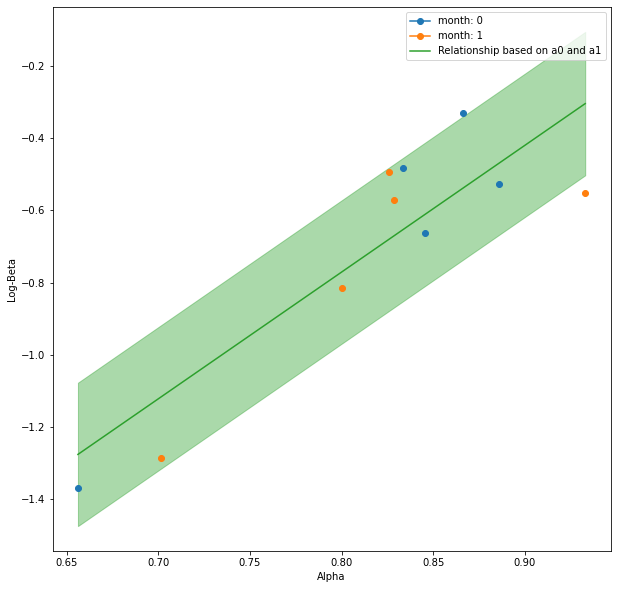

In [28]:
# Examining the parametric relationship between Alpha and Beta

alpha_mean_list = []
a0 = jnp.expand_dims(samples_1[f"a0"], -1)
a1 = jnp.expand_dims(samples_1[f"a1"], -1)
betavar = jnp.expand_dims(samples_1[f"betavar"], -1)
for k in np.arange(0, 2, 1):
    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    for j in np.arange(0, 5, 1):
        alphas = jnp.expand_dims(samples_1[f"alpha{k}"][:, j], -1)
        alpha_mean_list.append(jnp.mean(alphas))
        betas = jnp.expand_dims(samples_1[f"beta{k}"][:, j], -1)
        plt.plot(
            jnp.mean(alphas),
            jnp.mean(jnp.log(betas)),
            marker="o",
            color=color,
            label=f"month: {k}",
        )

x = [jnp.min(jnp.array(alpha_mean_list)), jnp.max(jnp.array(alpha_mean_list))]
y = jnp.mean(a0) + jnp.mean(a1) * jnp.array(x)
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(x, y, label="Relationship based on a0 and a1", color=color)
plt.fill_between(
    x,
    y1=y - jnp.mean(betavar),
    y2=y + jnp.mean(betavar),
    alpha=0.4,
    color=color,
)
plt.xlabel("Alpha")
plt.ylabel("Log-Beta")
# Below is some code for plotting a non-repeating legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())